<i>Alunos: Lara Destefani e Lucas Borges Pacheco</i>

### **Modelagem de dispersão atmosférica**



**Bibliotecas utilizadas no estudo**

In [424]:
import os
import math
import numpy
import pandas
import random
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

warnings.filterwarnings('ignore')

**Sumário de variáveis**

*h*: Altura geométrica da chaminé (m)

*Δh*: Altura de sobrelevação da pluma (m)

*H*: Altura total efetiva (m)

*d*: Diâmetro interno da chaminé (m)

*Vs*: Velocidade do efluente na saída da chaminé (m/s)

*u*: Velocidade média do vento, medida ou calculada na altura da chaminé (m/s)

*ΔT*: Temperatura do gás na chaminé menos a temperatura ambiente (K)

*Ts*: Temperatura do gás na saída da chaminé (K)

*Tamb*: Temperatura ambiente (K)

*p*: Pressão atmosférica (mb)

**Classes de estabilidade de Pasquill**

No presente estudo, aplicaremos a classificação de estabilidade atmosférica de Pasquill para categorizar as diferentes condições de estabilidade da atmosfera e, consequentemente, estimar os coeficientes de dispersão vertical e horizontal em relação à distância da fonte emissora.

In [425]:
def pasquill(i,u):
    if i == 'Forte':
        if u < 2:
            classe = 'A'
            print('Atmosfera extremamente instável!')
        elif 2 <= u < 3:
            classe = 'B'
            print('Atmosfera moderadamente instável!')
        elif 3 <= u < 5:
            classe = 'B'
            print('Atmosfera moderadamente instável!')
        elif 5 <= u < 6:
            classe = 'C'
            print('Atmosfera levemente instável!')
        else:
            classe = 'C'
            print('Atmosfera levemente instável!')

    elif i == 'Moderada':
        if u < 2:
            classe = 'B'
            print('Atmosfera moderadamente instável!')
        elif 2 <= u < 3:
            classe = 'B'
            print('Atmosfera moderadamente instável!')
        elif 3 <= u < 5:
            classe = 'C'
            print('Atmosfera levemente instável!')
        elif 5 <= u < 6:
            classe = 'D'
            print('Atmosfera neutra!')
        else:
            classe = 'D'
            print('Atmosfera neutra!')

    elif i == 'Fraca':
        if u < 2:
            classe = 'B'
            print('Atmosfera moderadamente instável!')
        elif 2 <= u < 3:
            classe = 'C'
            print('Atmosfera levemente instável!')
        elif 3 <= u < 5:
            classe = 'C'
            print('Atmosfera levemente instável!')
        elif 5 <= u < 6:
            classe = 'D'
            print('Atmosfera neutra!')
        else:
            classe = 'D'
            print('Atmosfera neutra!')
        
    elif i == 'Nublado':
        classe = 'D'
        print('Atmosfera neutra!')
    
    elif i == 'Noite, Claro':
        if u < 2:
            classe = 'F'
            print('Atmosfera moderadamente estável!')
        elif 2 <= u < 3:
            classe = 'E'
            print('Atmosfera levemente estável!')
        elif 3 <= u < 5:
            classe = 'D'
            print('Atmosfera neutra!')
        elif 5 <= u < 6:
            classe = 'D'
            print('Atmosfera neutra!')
        else:
            classe = 'D'
            print('Atmosfera neutra!')
        
    elif i == 'Noite, Nublado':
        if u <= 2:
            classe = 'E'
            print('Atmosfera levemente estável!')
        else:
            classe = 'D'
            print('Atmosfera neutra!')
    else:
        return 'Dados de entrada inválidos'

    return classe

**Coeficientes de dispersão**

Os coeficientes de dispersão são parâmetros fundamentais na modelagem da dispersão de poluentes atmosféricos, permitindo prever a concentração espacial dos poluentes nas direções horizontal e vertical a partir de uma fonte de emissão. Esses coeficientes de dispersão são derivados de medições empíricas e são uma representação da intensidade de turbulência atmosférica para diferentes ambientes, urbanos ou rurais.
- Coeficiente σy: Representa a dispersão horizontal lateralmente ao longo da direção do vento.
- Coeficiente σz: Representa a dispersão vertical, sendo afetado pela altura da camada limite.

In [426]:
def dispersion_coefficients(ambiente,classe,x):
    if ambiente == 'Urbano':
        if classe in ['A','B']:
            sigmaY = 0.32*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.24*x*(1+0.001*x)**(0.5)

        elif classe == 'C':
            sigmaY = 0.22*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.20*x
        
        elif classe == 'D':
            sigmaY = 0.16*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.14*x*(1+0.0003*x)**(-0.5)

        elif classe in ['E','F']:
            sigmaY = 0.11*x*(1+0.0004*x)**(-0.5)
            sigmaZ = 0.08*x*(1+0.0015*x)**(-0.5)
        
        else:
            print('A classe não existe!')

    elif ambiente == 'Rural':
        if classe == 'A':
            sigmaY = 0.22*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.20*x

        elif classe == 'B':
            sigmaY = 0.16*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.12*x

        elif classe == 'C':
            sigmaY = 0.11*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.08*x*(1+0.0002*x)**(-0.5)

        elif classe == 'D':
            sigmaY = 0.08*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.06*x*(1+0.0015*x)**(-0.5)

        elif classe == 'E':
            sigmaY = 0.06*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.03*x*(1+0.0003*x)**(-1)

        elif classe == 'F':
            sigmaY = 0.04*x*(1+0.0001*x)**(-0.5)
            sigmaZ = 0.016*x*(1+0.0003*x)**(-1)

        else:
            print('A classe não existe!')
        
    else:
        print('O ambiente não se enquadra em urbano ou rural')

    return sigmaY, sigmaZ

**Estimativa de sobrelevação da pluma**

A altura efetiva da pluma de uma chaminé (ht) refere-se à altura total em que os poluentes são liberados na atmosfera. Esta altura considera tanto a altura física da chaminé (hg) quanto a elevação adicional causada pela velocidade e temperatura dos gases emitidos (Δh). A partir dessa altura, a pluma começa a se dispersar.

***ht = hg + Δh***

O cálculo da altura de sobrelevação da pluma pode ser realizado utilizando diferentes modelos, dependendo das condições específicas de emissão e do ambiente. Neste estudo, foram empregados dois métodos distintos, levando em conta o efeito tip-downwash.

*Método de Davidson-Bryant*

In [427]:
def davidsonBryant(d,Vs,u,Ts,Tamb):
    deltaH = d*((Vs/u)**(1.4))*(1+((Ts-Tamb)/Ts))
    return deltaH

*Método de Holland*

In [428]:
def holland(classe,d,Vs,u,Ts,Tamb):  #Considera-se aumento e redução da altura para as diferentes condições de estabilidade atmosférica de Pasquill.
    deltaH = (d*Vs/u)*(1.5+2.68*(10**(-3))*1009.65*(Ts-Tamb)*d/Ts)

    #Atmosfera instável
    if classe in ['A','B','C']: 
        deltaH = 1.15*deltaH

    #Atmosfera estável
    elif classe in ['E','F']:
        deltaH = 0.85*deltaH

    #Atmosfera neutra
    elif classe == 'D':
        deltaH = deltaH

    return deltaH

**Efeito Tip-Downwash**

O efeito tip-downwash ocorre quando o fluxo de ar quente dos gases emitidos pela chaminé entra em contato com o ar ambiente mais frio e estável ao redor, resultando em turbulência na ponta da estrutura. Essa turbulência pode induzir um movimento descendente do ar próximo à extremidade da chaminé, direcionando a pluma em direção ao solo. Isso reduz a altura efetiva da emissão e tem um impacto significativo na dispersão dos poluentes na atmosfera.

Quando a velocidade dos gases emitidos é igual ou superior a 1,5 vezes a velocidade do vento, o efeito tip-downwash geralmente não é relevante. No entanto, se a velocidade de saída for menor, uma altura de chaminé reduzida (hg') pode ser calculada usando a equação abaixo.

In [429]:
def tipDownwash(classe,method,Vs,u,hg,d,Ts,Tamb):
    if method == 'Holland':
        if Vs > 1.5*u:
            deltaH = holland(classe,d,Vs,u,Ts,Tamb)
            ht = deltaH + hg
            print('A pluma subiu!')
        else:
            deltaH = holland(classe,d,Vs,u,Ts,Tamb)
            hg = hg + 2*d*((Vs/u)-1.5)
            ht = deltaH + hg
            print('A pluma caiu!')
    
    elif method == 'Davidson-Bryant':
        if Vs > 1.5*u:
            deltaH = davidsonBryant(d,Vs,u,Ts,Tamb)
            ht = deltaH + hg
            print('A pluma subiu!')
        else:
            deltaH = davidsonBryant(d,Vs,u,Ts,Tamb)
            hg = hg + 2*d*((Vs/u)-1.5)
            ht = deltaH + hg
            print('A pluma caiu!')

    print(f'Altura geométrica da chaminé: {hg :.2f} m')
    print(f'Altura de sobrelevação da pluma: {deltaH :.2f} m')
    print(f'Altura total efetiva: {ht :.2f} m')
    return ht

**Modelo Gaussiano**

O modelo Gaussiano é uma abordagem para a dispersão atmosférica onde a concentração de poluentes segue uma distribuição normal tanto na direção horizontal quanto na vertical. A função desse modelo para calcular a concentração de poluentes em um ponto específico do espaço, originada de uma fonte de emissão.

In [430]:
#Modelo Gaussiano
def modeloGaussiano(qs,sigmaY,sigmaZ,u,y,z,ht):
    term1 = qs/(2*numpy.pi*sigmaY*sigmaZ*u)
    term2 = numpy.exp((-(y)**2)/(2*(sigmaY)**2))
    term3 = numpy.exp((-(z-ht)**2)/(2*(sigmaZ)**2)) + numpy.exp((-(z+ht)**2)/(2*(sigmaZ)**2))
    result = term1*term2*term3
    result = result*10**6
    return result

#Malha bidimensional, considerando distâncias de 100 a 10000 m pela Formulação de Briggs.
x = numpy.linspace(0,30000,500)
y = numpy.linspace(-5000,5000,500)
xx,yy = numpy.meshgrid(x,y)

**Simulações**

No presente estudo, foram realizadas simulações com o Modelo Gaussiano, utilizando diversas classes de estabilidade, diferentes velocidades do vento e variadas alturas de chaminé. Devido à natureza estacionária das simulações, foi empregada a taxa média de emissão de **monóxido de carbono** (31,33 g/s), o principal poluente liberado na atmosfera pela fundição de ferro da empresa Embraco, que se destaca por suas elevadas taxas de emissão. A Resolução CONAMA nº 491 define o padrão de qualidade do ar para o monóxido de carbono como sendo de 9 ppm (partes por milhão).

Abaixo estão funções para os principais gráficos que ajudam a entender a dispersão dos poluentes na atmosfera. O gráfico de contorno fornece uma visão global da distribuição espacial, enquanto os gráficos de corte fornecem detalhes sobre a variação da concentração ao longo de direções específicas.

In [431]:
def dispersion(results_model):
    plt.figure(figsize=(15,10))
    plt.rc('font',family='Montserrat')
    contour = plt.contourf(xx,yy,results_model+0.1,norm = LogNorm(),cmap='viridis')
    plt.title('Dispersão bidimensional do Monóxido de Carbono', fontsize=15)
    plt.xlabel('Distância na direção x (m)', fontsize=13)
    plt.ylabel('Distância na direção y (m)', fontsize=13)
    plt.xlim(left=0)
    cbar = plt.colorbar(contour)
    cbar.set_label('Concentração (g/m³)', fontsize=13)
    cbar.ax.tick_params(labelsize=11)
    plt.grid(alpha=0.1)
    plt.show()

#Perfil de concentração do poluente ao longo da direção do vento
def profile1(results_model):
    plt.figure(figsize=(25,6))
    plt.rc('font',family='Montserrat')
    plt.plot(x,results_model[250,:],color='dodgerblue',alpha=0.9,linewidth=1)
    plt.axhline(10.31,color='red',alpha=0.9,linewidth=1,linestyle='--',label='Limite CONAMA 491')
    plt.title('Perfil de concentração (corte sobre o eixo x)', fontsize=15)
    plt.xlabel('Distância (m)', fontsize=13)
    plt.ylabel('Concentração (g/m³)', fontsize=13)
    plt.grid(alpha=0.2)
    plt.margins(y=0.2)
    plt.show()

#Perfil de concentração do poluente ao longo da direção perpendicular ao vento
def profile2(results_model):
    plt.figure(figsize=(25,6))
    plt.rc('font',family='Montserrat')
    plt.plot(x,results_model[:,100],color='dodgerblue',alpha=0.9,linewidth=1,label='Dados observados')
    plt.axhline(10.31,color='red',alpha=0.9,linewidth=1,linestyle='--',label='Limite CONAMA 491')
    plt.title('Perfil de concentração (corte sobre o eixo y)', fontsize=15)
    plt.xlabel('Distância (m)', fontsize=13)
    plt.ylabel('Concentração (g/m³)', fontsize=13)
    plt.grid(alpha=0.2)
    plt.margins(y=0.2)
    plt.show()

Implementação de um loop automatizado para realizar múltiplas simulações estacionárias, variando as classes, os ambientes, a altura geométrica da chaminé, o método de cálculo da sobrelevação da pluma e a velocidade do vento. As simulações foram conduzidas com alturas de chaminé variando entre 10 e 200 metros, e velocidade média do vento variando de 0 a 12 m/s.

1° SIMULAÇÃO
------------------------------
Atmosfera levemente instável!
Classe de estabilidade de Pasquil: C
Condição: Fraca
Tipo de ambiente: Urbano
Velocidade do vento: 4.05 m/s
Método de cálculo da sobrelevação da pluma: Holland
A pluma subiu!
Altura geométrica da chaminé: 62.32 m
Altura de sobrelevação da pluma: 4.44 m
Altura total efetiva: 66.76 m


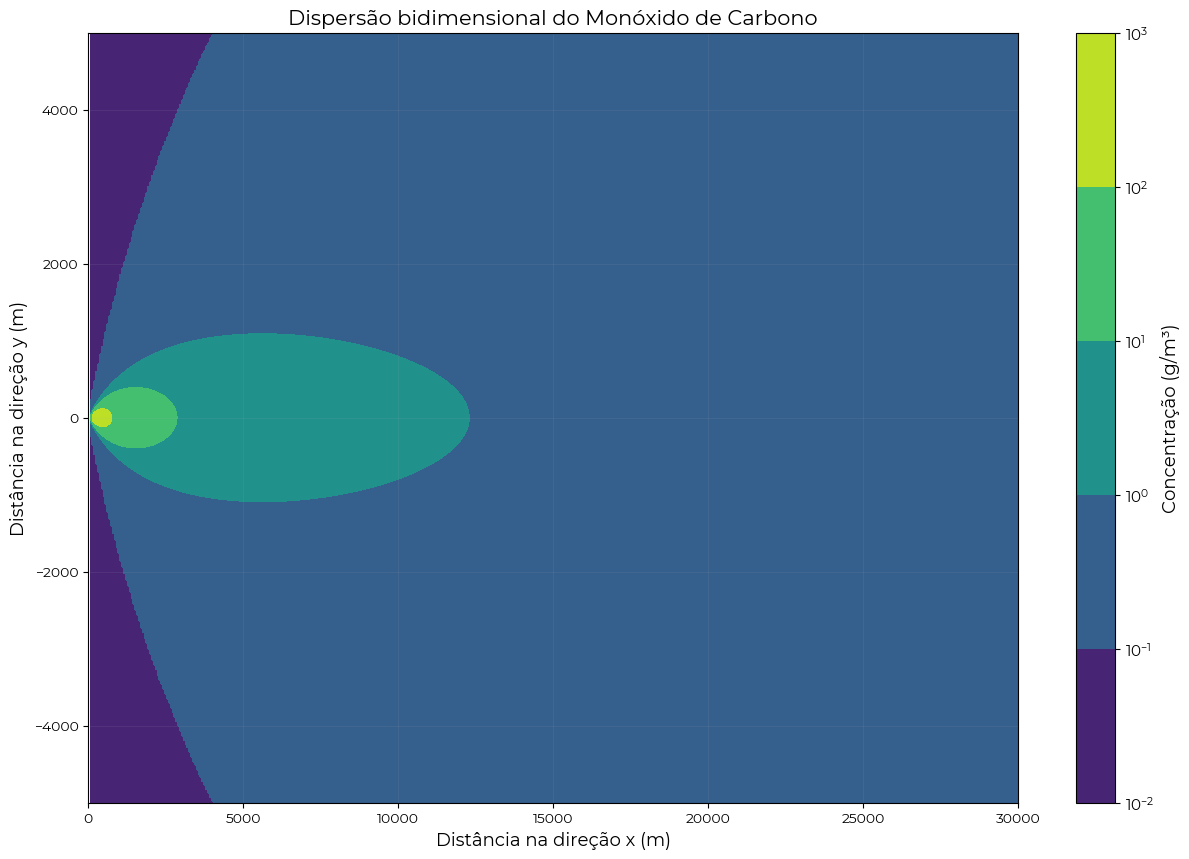

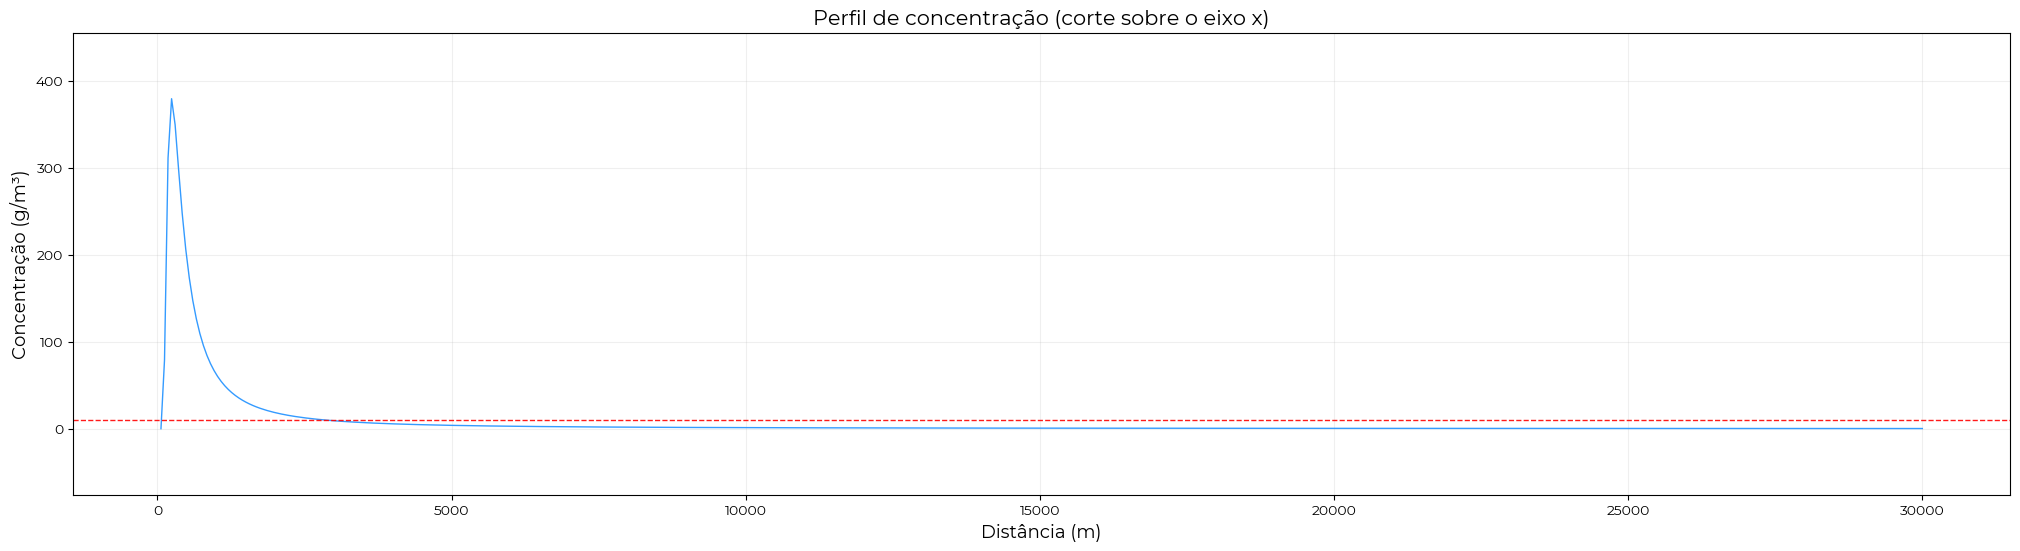

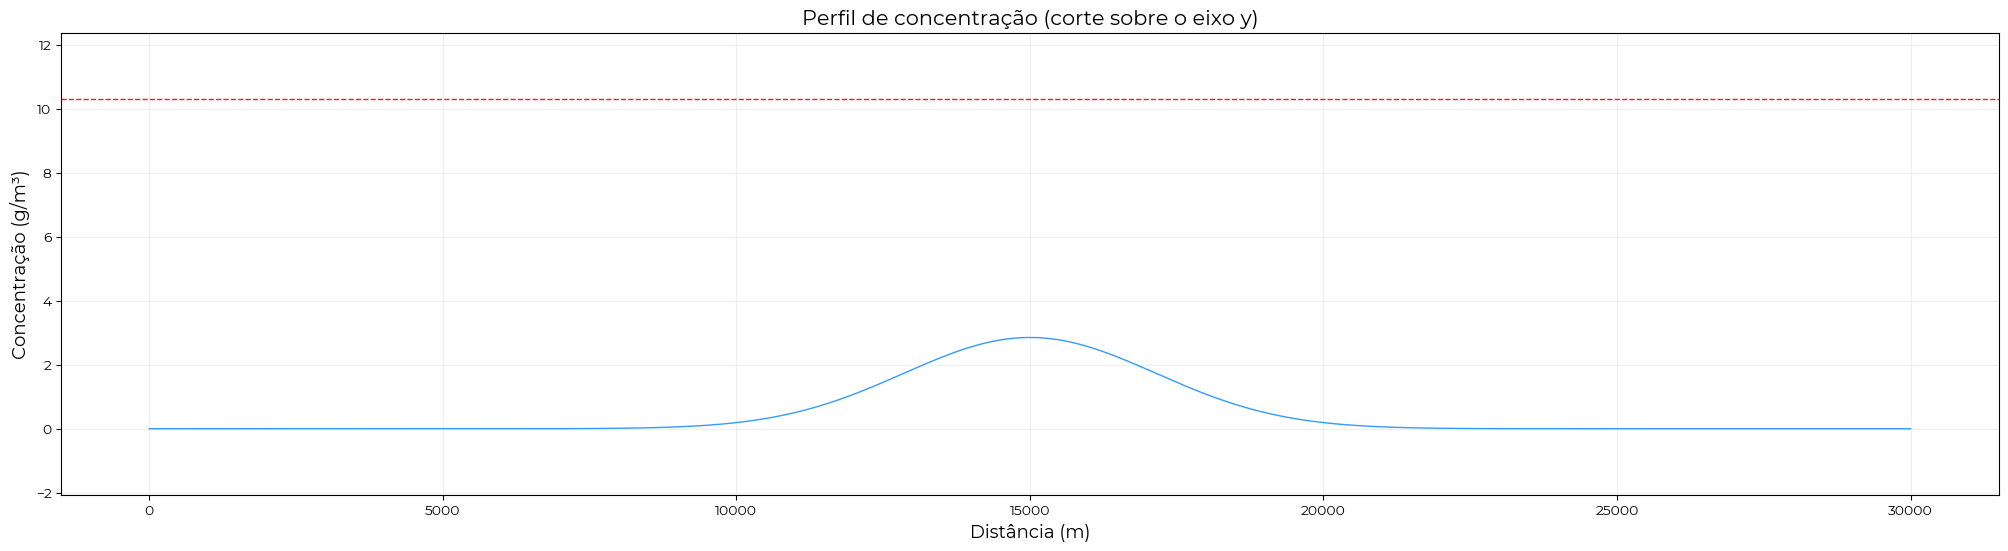

2° SIMULAÇÃO
------------------------------
Atmosfera neutra!
Classe de estabilidade de Pasquil: D
Condição: Fraca
Tipo de ambiente: Urbano
Velocidade do vento: 9.57 m/s
Método de cálculo da sobrelevação da pluma: Davidson-Bryant
A pluma caiu!
Altura geométrica da chaminé: 135.40 m
Altura de sobrelevação da pluma: 1.09 m
Altura total efetiva: 136.49 m


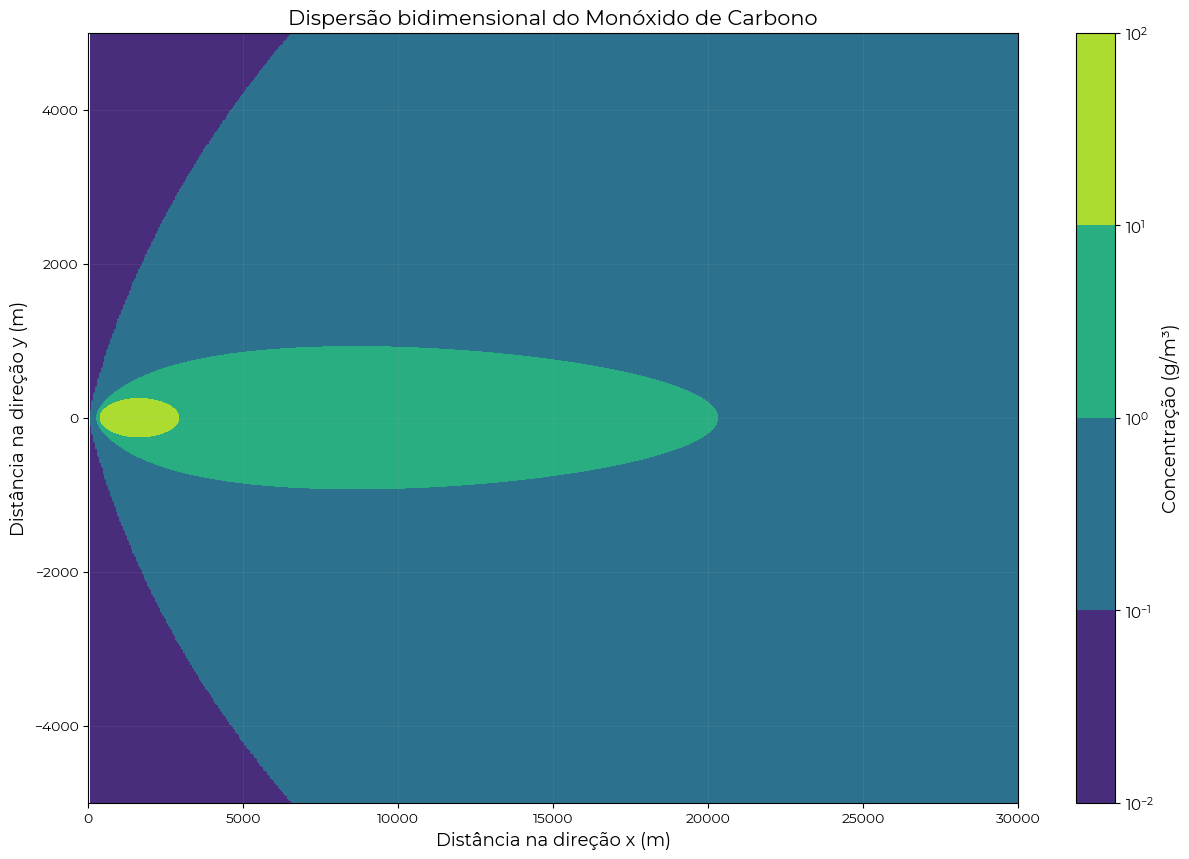

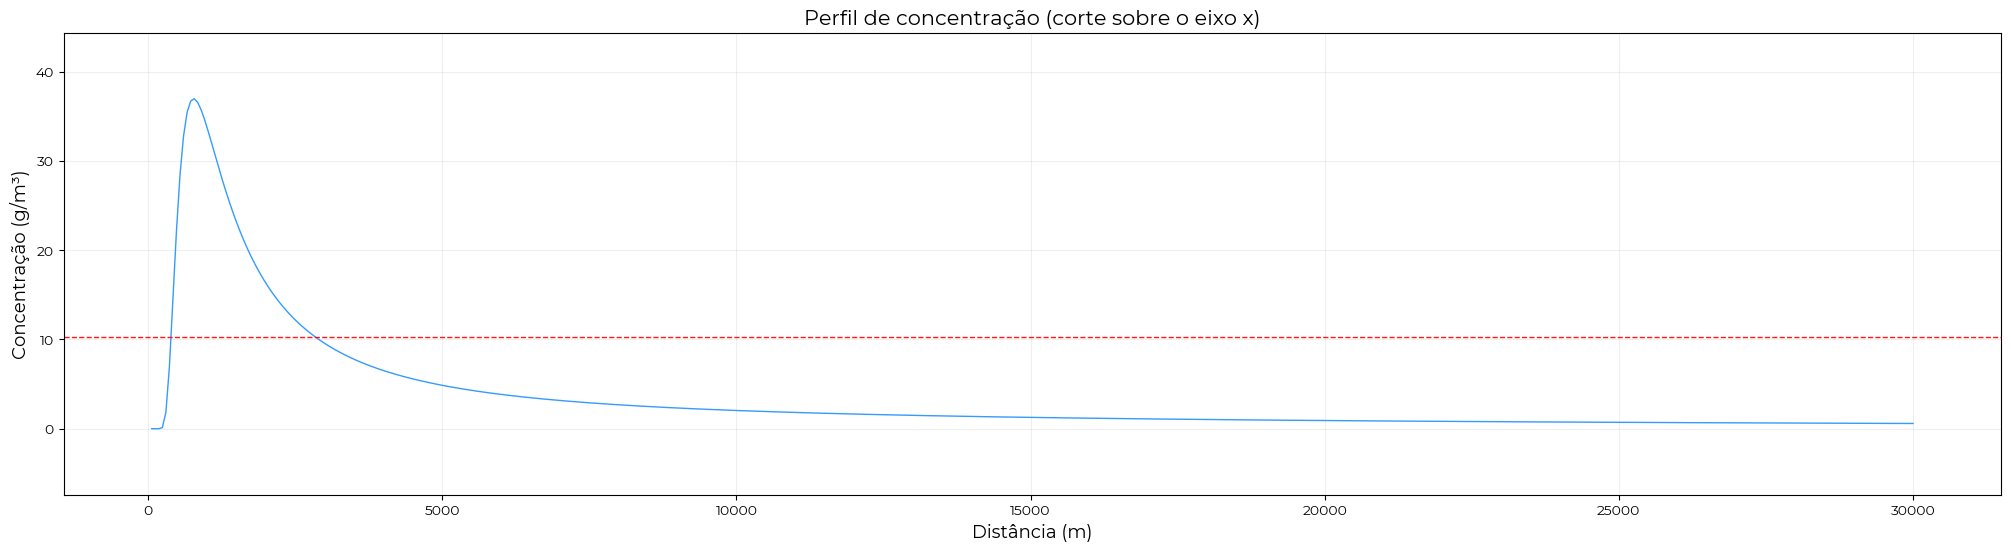

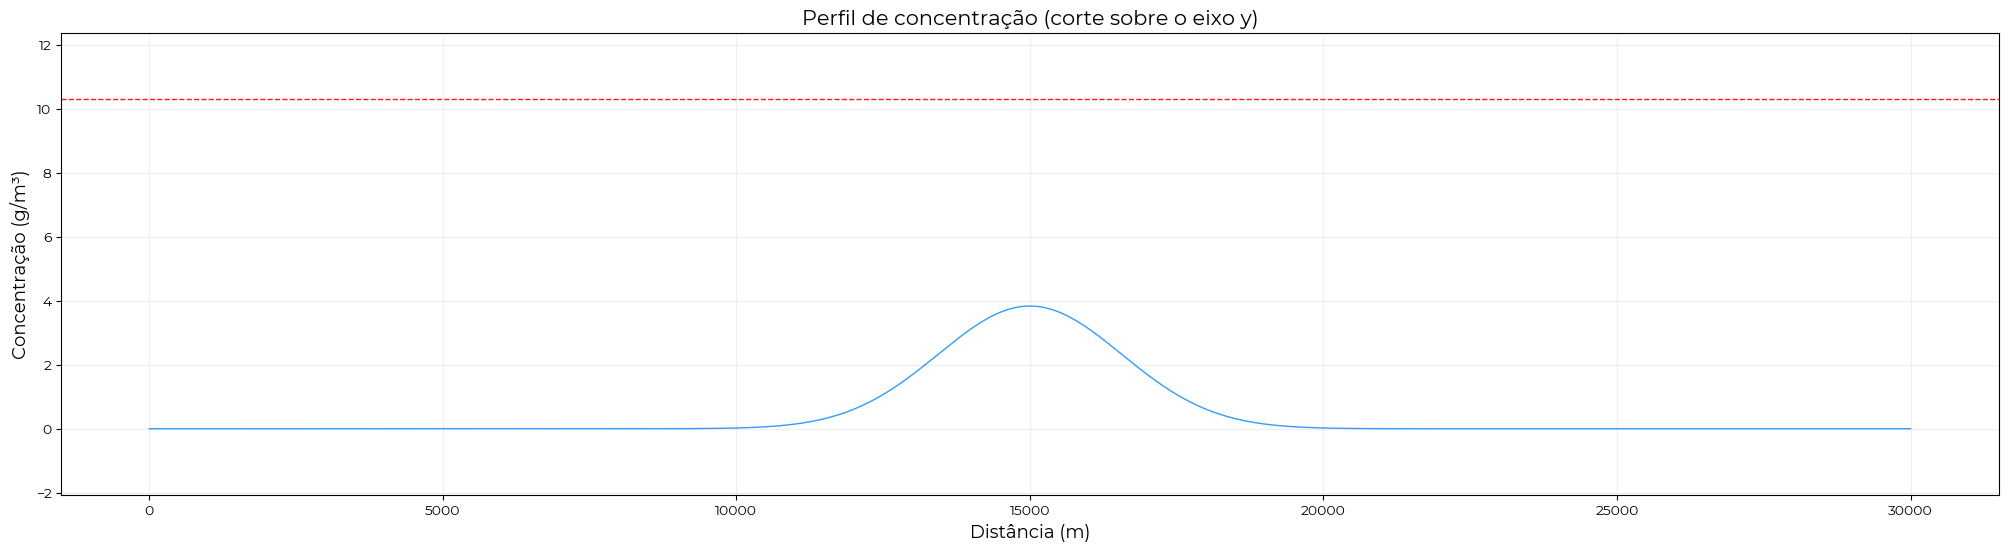

3° SIMULAÇÃO
------------------------------
Atmosfera moderadamente instável!
Classe de estabilidade de Pasquil: B
Condição: Forte
Tipo de ambiente: Urbano
Velocidade do vento: 4.06 m/s
Método de cálculo da sobrelevação da pluma: Davidson-Bryant
A pluma subiu!
Altura geométrica da chaminé: 106.60 m
Altura de sobrelevação da pluma: 3.61 m
Altura total efetiva: 110.21 m


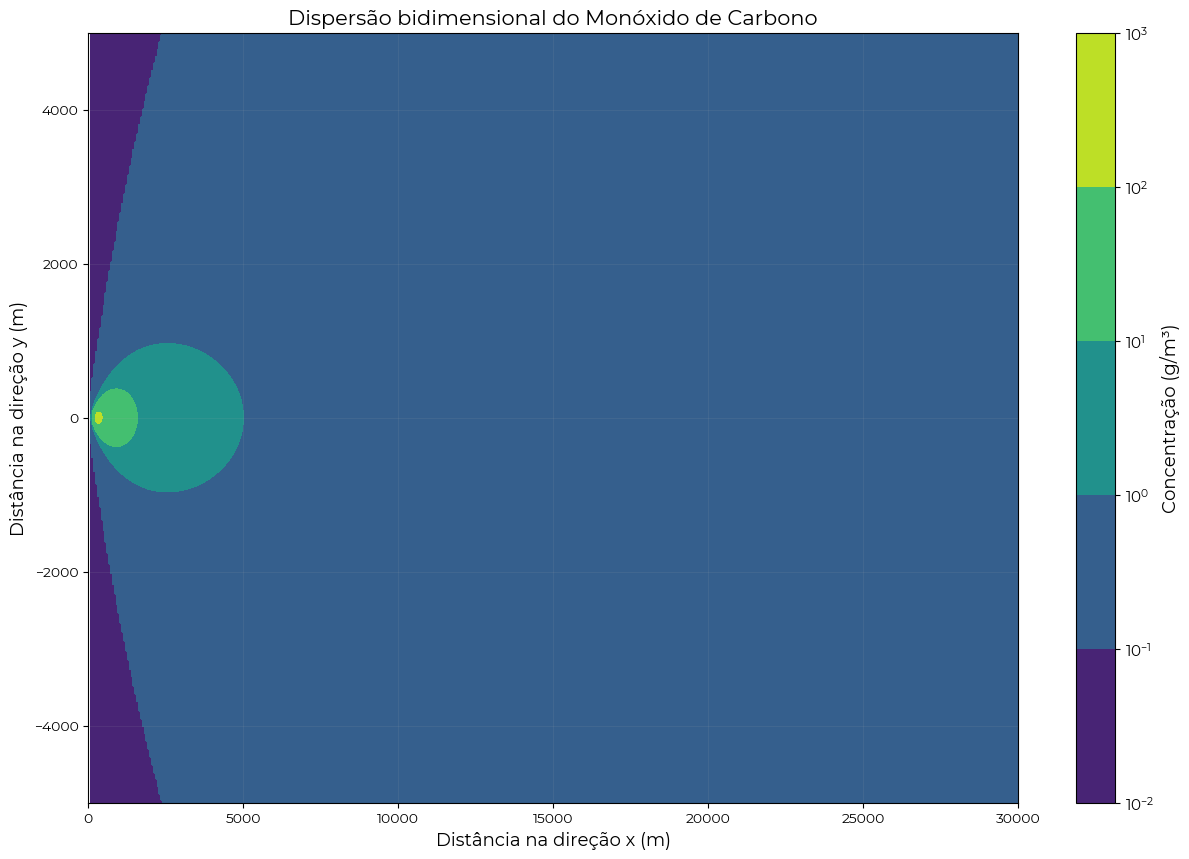

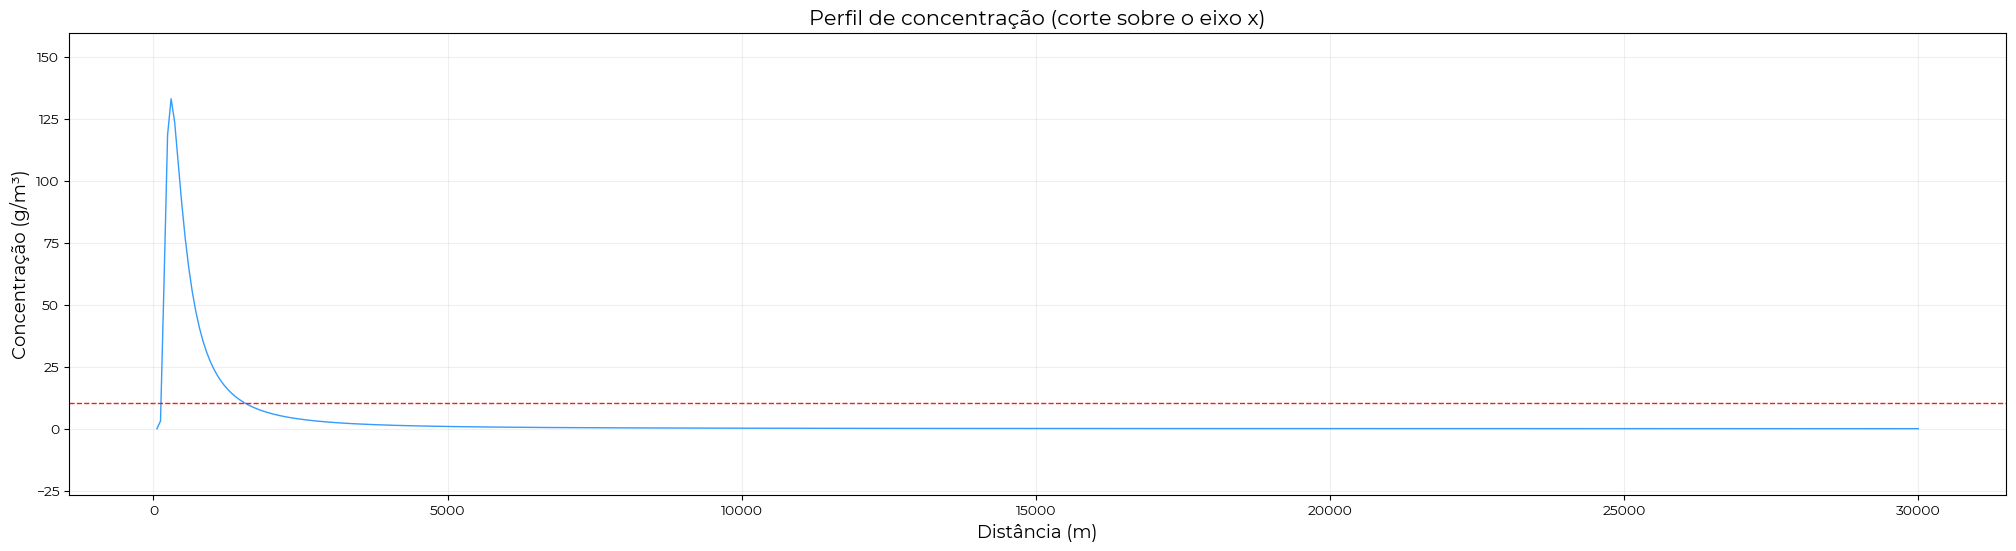

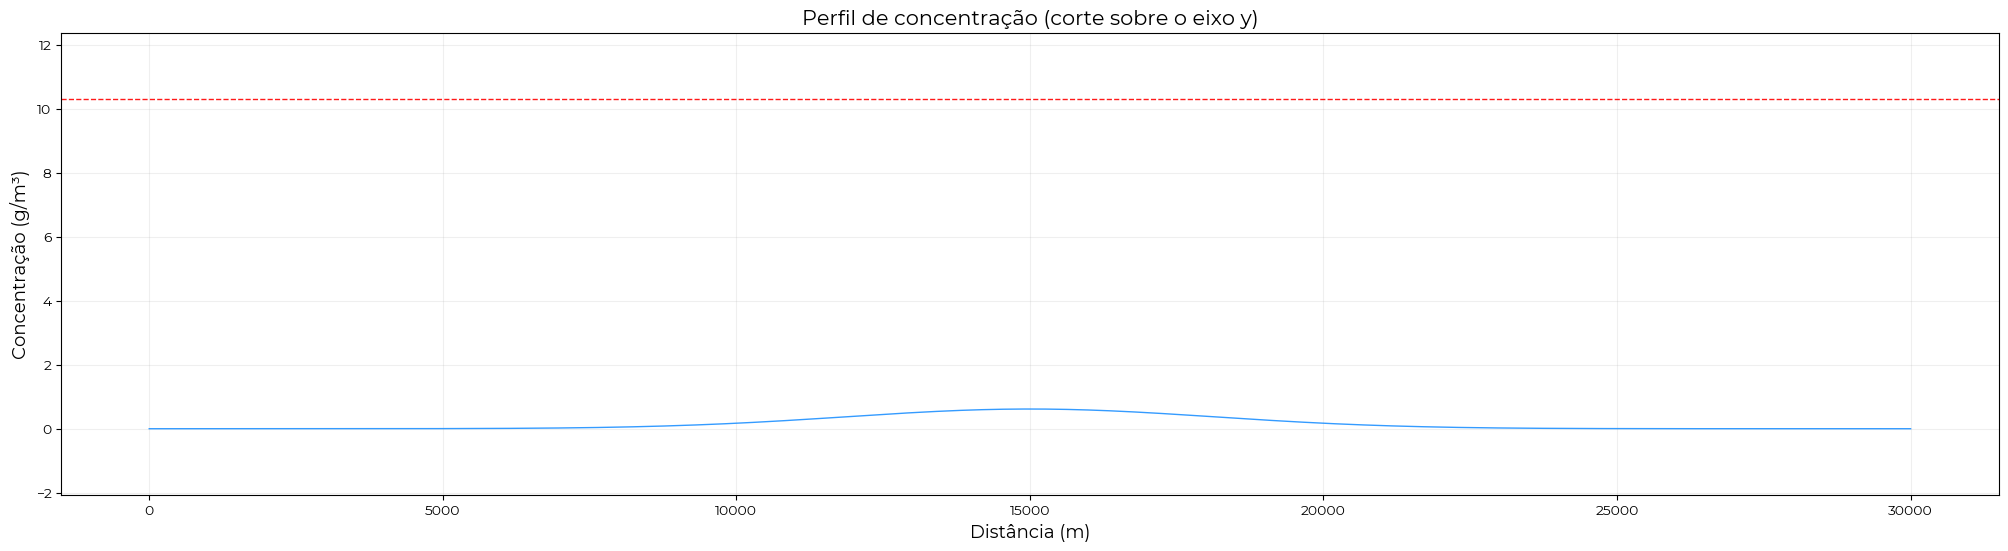

4° SIMULAÇÃO
------------------------------
Atmosfera neutra!
Classe de estabilidade de Pasquil: D
Condição: Nublado
Tipo de ambiente: Rural
Velocidade do vento: 5.21 m/s
Método de cálculo da sobrelevação da pluma: Holland
A pluma subiu!
Altura geométrica da chaminé: 131.42 m
Altura de sobrelevação da pluma: 3.00 m
Altura total efetiva: 134.42 m


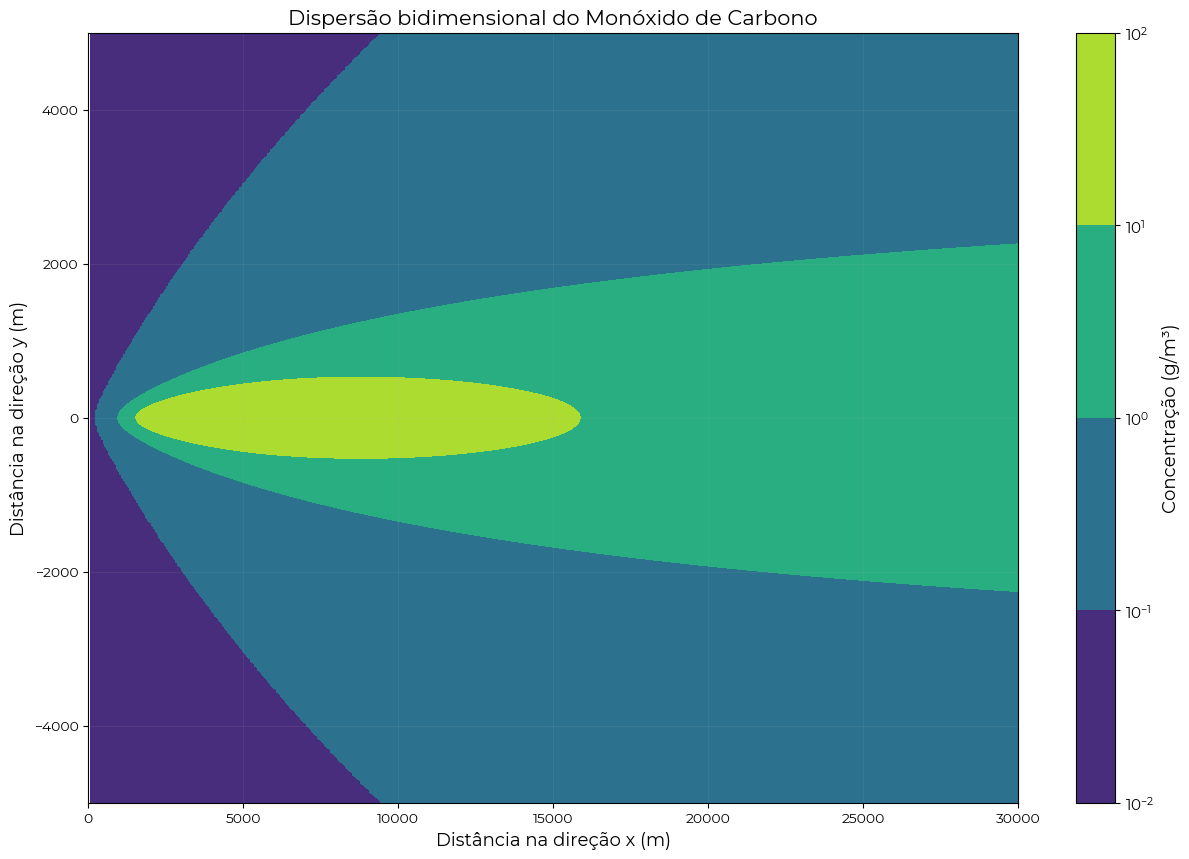

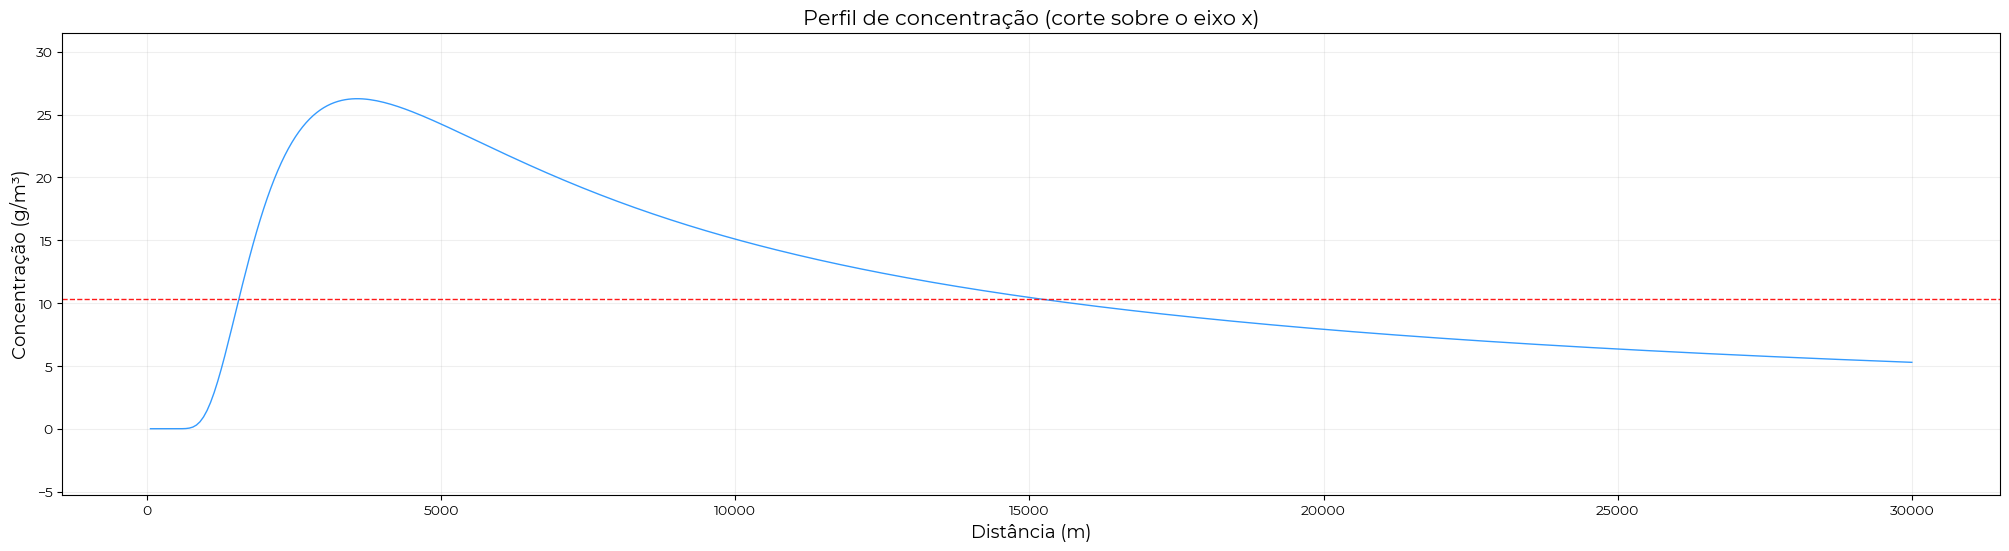

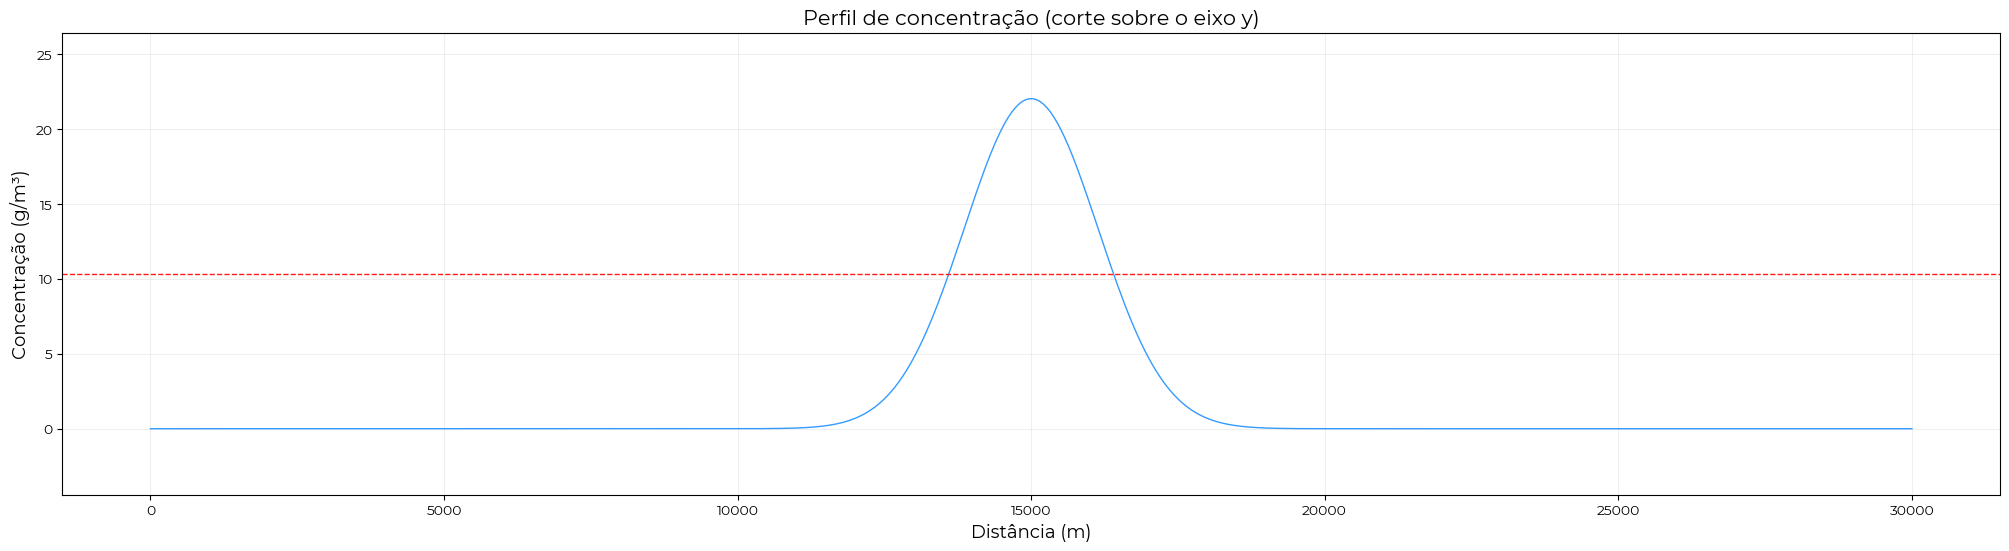

5° SIMULAÇÃO
------------------------------
Atmosfera levemente instável!
Classe de estabilidade de Pasquil: C
Condição: Fraca
Tipo de ambiente: Rural
Velocidade do vento: 2.99 m/s
Método de cálculo da sobrelevação da pluma: Holland
A pluma subiu!
Altura geométrica da chaminé: 60.03 m
Altura de sobrelevação da pluma: 6.01 m
Altura total efetiva: 66.04 m


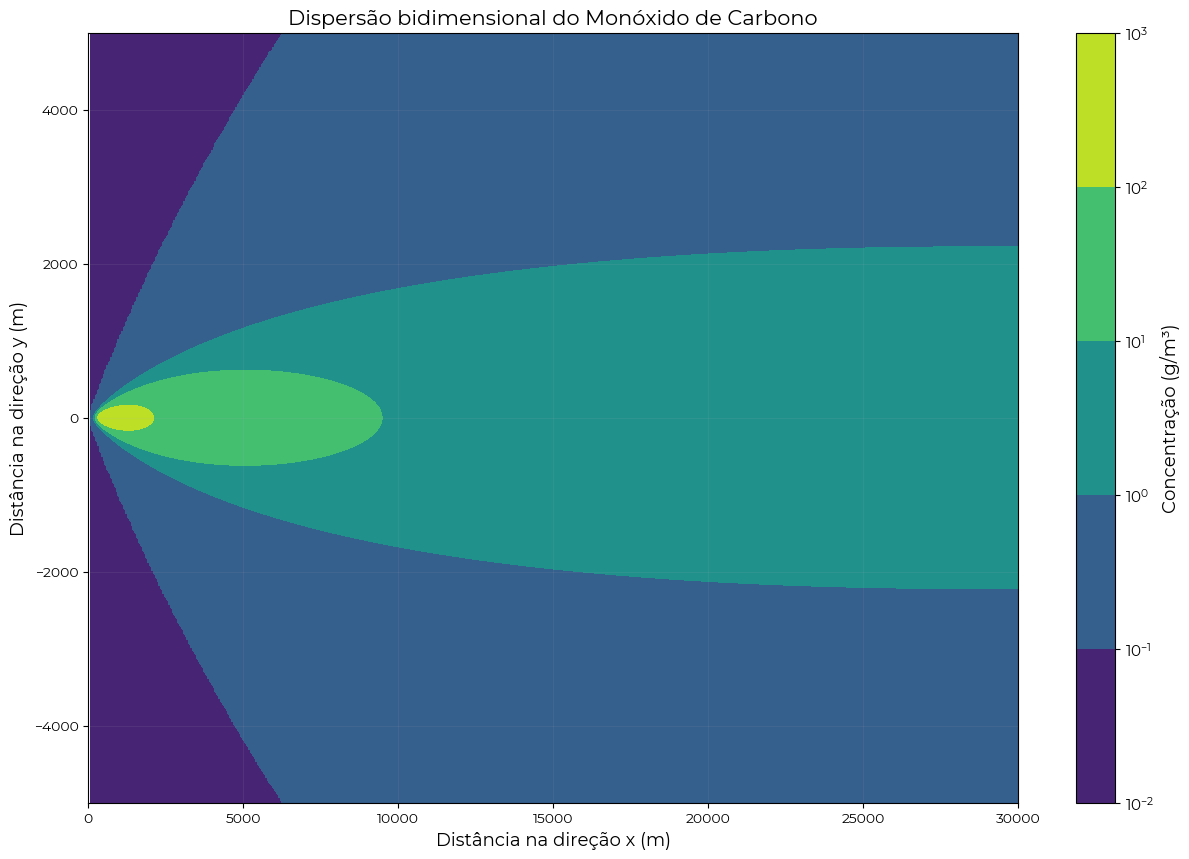

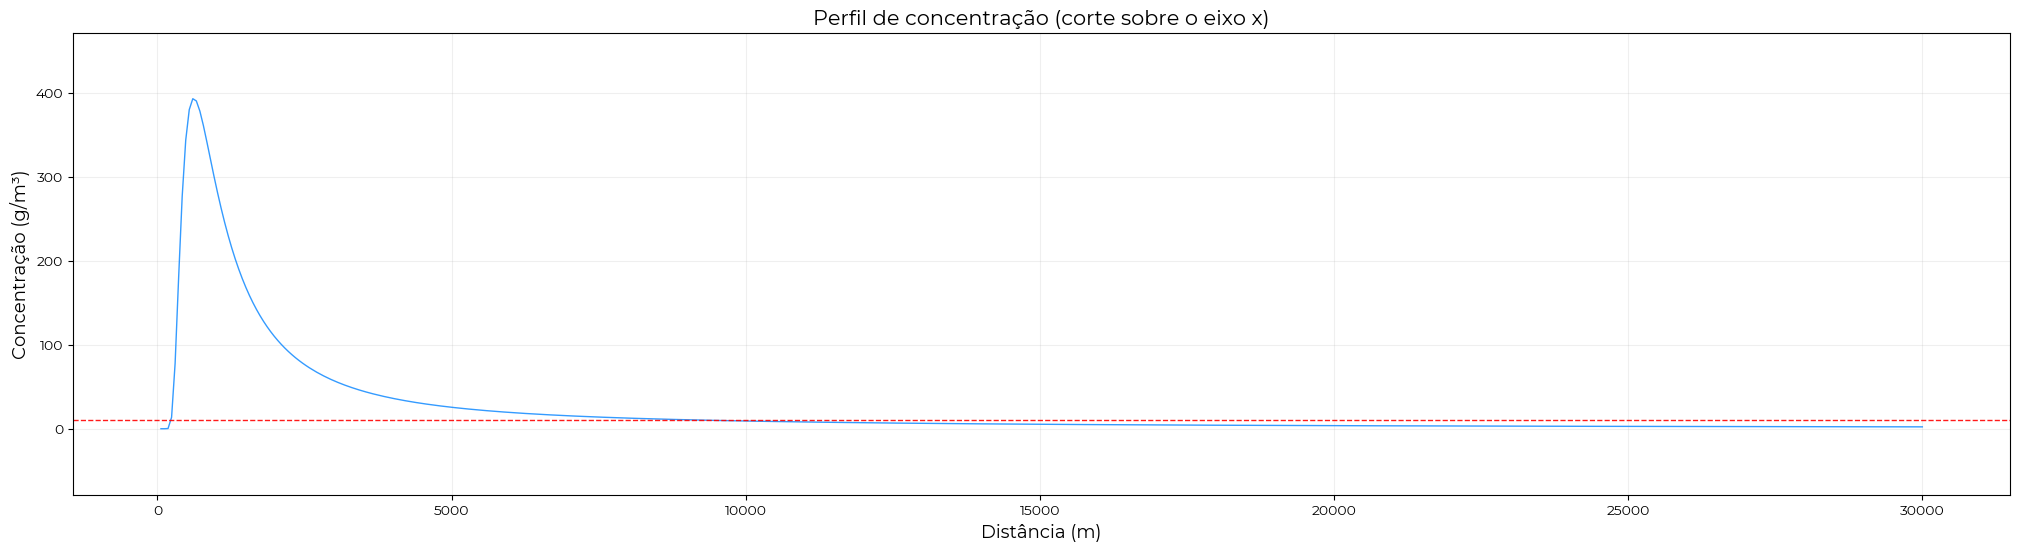

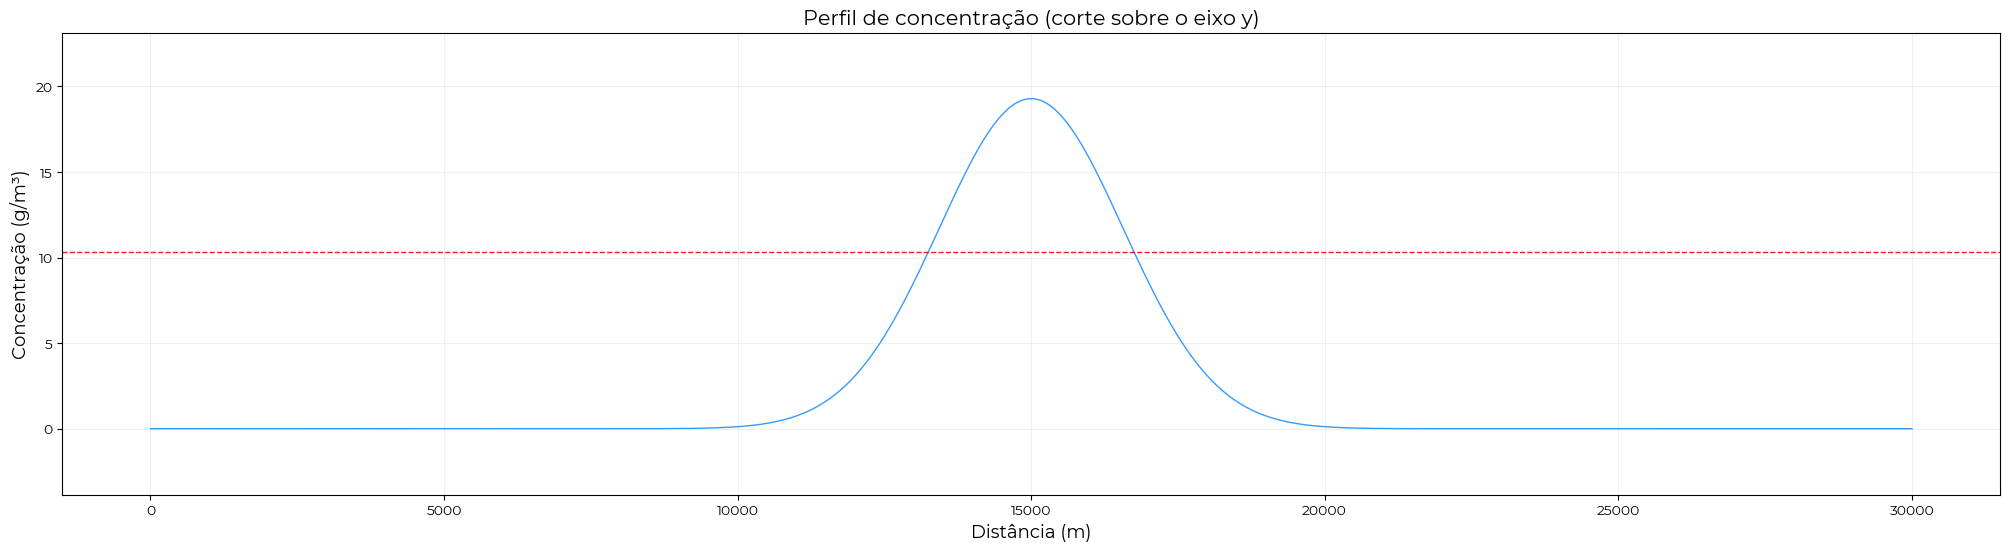

In [432]:
ambientes = ['Urbano','Rural']
radiacao = ['Forte','Moderada','Fraca','Noite, Claro','Noite, Nublado','Nublado']
methods = ['Davidson-Bryant','Holland']

k = 1
for i in range(5):
    #Parâmetros fixos
    qs = 31.33
    y = 0
    z = 1.5
    d = 1
    Vs = 10
    Ts = 300
    Tamb = 293

    #Parâmetros aleatórios
    u = numpy.random.uniform(0,12)
    hg =  numpy.random.uniform(10,200)
    ambiente = random.choice(ambientes)
    i = random.choice(radiacao)
    method = random.choice(methods)

    #Funções de cálculo e plotagem
    print(f'{k}° SIMULAÇÃO')
    print(30*'-')
    classe = pasquill(i,u)
    print(f'Classe de estabilidade de Pasquil: {classe}')
    print(f'Condição: {i}')
    print(f'Tipo de ambiente: {ambiente}')
    print(f'Velocidade do vento: {u :.2f} m/s')
    print(f'Método de cálculo da sobrelevação da pluma: {method}')
    sigmaY, sigmaZ = dispersion_coefficients(ambiente,classe,xx)
    ht = tipDownwash(classe,method,Vs,u,hg,d,Ts,Tamb)
    results_model = modeloGaussiano(qs,sigmaY,sigmaZ,u,yy,z,ht)
    dispersion(results_model)
    profile1(results_model)
    profile2(results_model)
    k+=1

**Altura da chaminé**

A altura da chaminé necessária para garantir que as concentrações de monóxido de carbono não excedam os padrões da Resolução CONAMA 491 foi determinada utilizando o Artigo 8 da Resolução n° 054/06 da SEMA para o lançamento de efluentes à atmosfera através de dutos ou chaminés. A resolução especifica que a chaminé deve ter uma altura mínima de 10 metros acima do solo ou ser mais alta conforme um dos seguintes critérios, resultando na maior altura calculada:
- 3 metros acima da edificação onde a fonte potencialmente poluidora será instalada.
- Altura física da chaminé calculada de acordo com fórmula **Af = At - E** ou 10 metros, o que for maior.
- 5 metros acima da altura da residência mais alta num raio de 300 m ou num raio de 30 vezes a altura da chaminé, calculada a partir do maior valor encontrado de acordo com os itens a e b, caso este raio seja maior.

Considerando o estudo meteorológico anterior, foram utilizados os seguintes parâmetros: velocidade média do vento na região de 1.959 m/s, predominância do quadrante norte, temperatura ambiente média de 22,17 °C (ou 295,17 K), diâmetro da chaminé de 1 metro, temperatura de saída do efluente de 300 K e velocidade de saída do efluente de 10 m/s. Além disso, considerando o fator de periculosidade do monóxido de carbono de 0,07, foi possível calcular a altura física da chaminé (Af).

In [433]:
#Dados de entrada
qs = 31.33
d = 1
Vs = 10
Ts = 300
Tamb = 295.17
u = 1.959
p = 1009.65

#Cálculo da altura física da chaminé para a fonte emissora
at = 3.5*(qs*3.6*0.07)**0.52
e = (Vs*d/u)*(1.5+(0.00268*p*(Ts-Tamb)*d/Ts))
af = at - e

if af >= 10:
    hg = af
    print(f'A altura física da chaminé deve ser de {at :.2f} metros.')

if af < 10:
    hg = 10
    print(f'A altura da chaminé deve ser de 10 metros.')

A altura da chaminé deve ser de 10 metros.
